# No Randomization Fix

**Description**: Split bursts belonging to the same device, which is not performing randomization into different ones, based on the DS Channel parameter (when it decreases, apply a new, random, MAC Address).

**Inputs**: `data/hex/*`

**Outputs**: `data/interim/hex_random.csv`

## Notebook Setup

### Libraries

In [1]:
import fancyData
import fancyPlots
import pandas as pd
from rich import traceback
from rich.progress import Progress

In [2]:
traceback.install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x10ebba9f0>>

### Configurations

In [3]:
from configparser import ConfigParser

config = ConfigParser()
config.read("../config.ini")

['../config.ini']

## HEX Data

In [4]:
hex_path = config["DEFAULT"]["hex_path"]
df_hex = fancyData.load_and_concat_csv(hex_path)

In [5]:
df_hex

,Timestamp,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,SSID,Supported Rates,Extended Supported Rates,VHT Capabilities,HE Capabilities,Length,Label
0,1684590721.864466,d2:6b:aa:b5:fb:ea,1,1,2d001bff00000000000000000000000000000000000000...,0000080000000040000020,NaN,NaN,82848b96,0c1218243048606c,NaN,23010808180080203002000d009f08000000fdfffdff39...,135,iPhone12Pro_C
1,1684590721.884716,d2:6b:aa:b5:fb:ea,1,1,2d001bff00000000000000000000000000000000000000...,0000080000000040000020,NaN,NaN,82848b96,0c1218243048606c,NaN,23010808180080203002000d009f08000000fdfffdff39...,135,iPhone12Pro_C
2,1684590721.910542,d2:6b:aa:b5:fb:ea,6,6,2d001bff00000000000000000000000000000000000000...,0000080000000040000020,NaN,NaN,82848b96,0c1218243048606c,NaN,23010808180080203002000d009f08000000fdfffdff39...,135,iPhone12Pro_C
3,1684590721.930789,d2:6b:aa:b5:fb:ea,6,6,2d001bff00000000000000000000000000000000000000...,0000080000000040000020,NaN,NaN,82848b96,0c1218243048606c,NaN,23010808180080203002000d009f08000000fdfffdff39...,135,iPhone12Pro_C
4,1684590721.968746,d2:6b:aa:b5:fb:ea,11,11,2d001bff00000000000000000000000000000000000000...,0000080000000040000020,NaN,NaN,82848b96,0c1218243048606c,NaN,23010808180080203002000d009f08000000fdfffdff39...,135,iPhone12Pro_C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76699,1623847860.708628,ec:9b:f3:75:8e:40,11,9,631117ffff000000000000000000000000000000000000...,0000088001400040,506f9a1010,NaN,02040b16,0c1218243048606c,NaN,NaN,162,SamsungS6_H
76700,1623847860.732495,ec:9b:f3:75:8e:40,11,10,631117ffff000000000000000000000000000000000000...,0000088001400040,506f9a1010,NaN,02040b16,0c1218243048606c,NaN,NaN,162,SamsungS6_H
76701,1623847860.752909,ec:9b:f3:75:8e:40,11,10,631117ffff000000000000000000000000000000000000...,0000088001400040,506f9a1010,NaN,02040b16,0c1218243048606c,NaN,NaN,162,SamsungS6_H
76702,1623847860.776777,ec:9b:f3:75:8e:40,11,11,631117ffff000000000000000000000000000000000000...,0000088001400040,506f9a1010,NaN,02040b16,0c1218243048606c,NaN,NaN,162,SamsungS6_H


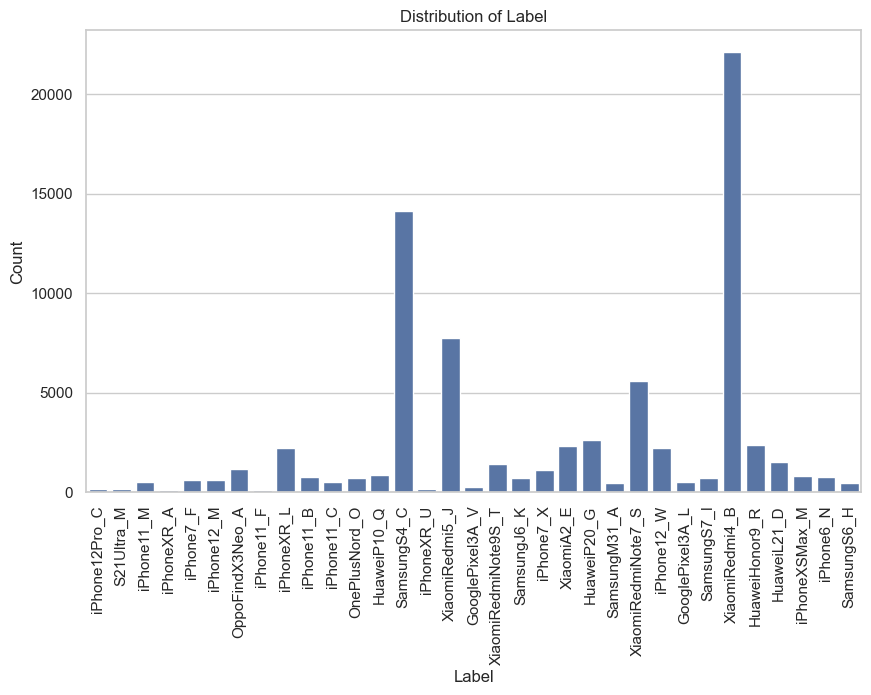

In [6]:
fancyPlots.plot_label_distribution(df_hex, "Label")

In [7]:
def generate_random_mac():
    import random

    return ":".join(f"{random.randint(0, 255):02x}" for _ in range(6))

In [8]:
def split_non_random_bursts(data: pd.DataFrame, labels: list) -> pd.DataFrame:
    for label in labels:
        # Filter rows with the specific label
        label_data = data[data["Label"] == label]
        label_data = label_data.sort_values(by="Timestamp").reset_index()

        # Initialize variables to track the current burst
        random_mac = generate_random_mac()  # Initial random MAC for the first burst
        start_index = 0  # Start index of the current burst

        for i in range(1, len(label_data)):
            # Debugging output
            # print(f"Current DS Channel: {label_data.at[i, 'DS Channel']}, Previous DS Channel: {label_data.at[i - 1, 'DS Channel']}")

            # Check for a drop in DS Channel
            if label_data.at[i, "DS Channel"] < label_data.at[i - 1, "DS Channel"]:
                # Update all rows in the current burst with the current random MAC
                for j in range(start_index, i):
                    original_index = label_data.loc[j, "index"]
                    data.loc[original_index, "MAC Address"] = random_mac

                # Generate a new random MAC for the next burst
                random_mac = generate_random_mac()
                # print(f"Channel dropped; assigning new MAC: {random_mac}")

                # Update the start index for the next burst
                start_index = i

        # Update the last burst (from the last drop to the end)
        for j in range(start_index, len(label_data)):
            original_index = label_data.loc[j, "index"]
            data.loc[original_index, "MAC Address"] = random_mac

    return data


In [9]:
non_randomizing_devices = [
    "iPhone12Pro_C",
    "SamsungS6_H",
    "HuaweiL21_D",
    "HuaweiP10_Q",
    "HuaweiP20_G",
    "SamsungS4_C",
]

In [10]:
df_hex_random = split_non_random_bursts(df_hex, non_randomizing_devices)

In [11]:
df_hex_random

,Timestamp,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,SSID,Supported Rates,Extended Supported Rates,VHT Capabilities,HE Capabilities,Length,Label
0,1684590721.864466,cc:a8:f4:cf:e3:27,1,1,2d001bff00000000000000000000000000000000000000...,0000080000000040000020,NaN,NaN,82848b96,0c1218243048606c,NaN,23010808180080203002000d009f08000000fdfffdff39...,135,iPhone12Pro_C
1,1684590721.884716,cc:a8:f4:cf:e3:27,1,1,2d001bff00000000000000000000000000000000000000...,0000080000000040000020,NaN,NaN,82848b96,0c1218243048606c,NaN,23010808180080203002000d009f08000000fdfffdff39...,135,iPhone12Pro_C
2,1684590721.910542,cc:a8:f4:cf:e3:27,6,6,2d001bff00000000000000000000000000000000000000...,0000080000000040000020,NaN,NaN,82848b96,0c1218243048606c,NaN,23010808180080203002000d009f08000000fdfffdff39...,135,iPhone12Pro_C
3,1684590721.930789,cc:a8:f4:cf:e3:27,6,6,2d001bff00000000000000000000000000000000000000...,0000080000000040000020,NaN,NaN,82848b96,0c1218243048606c,NaN,23010808180080203002000d009f08000000fdfffdff39...,135,iPhone12Pro_C
4,1684590721.968746,1f:ba:cb:da:c3:8b,11,11,2d001bff00000000000000000000000000000000000000...,0000080000000040000020,NaN,NaN,82848b96,0c1218243048606c,NaN,23010808180080203002000d009f08000000fdfffdff39...,135,iPhone12Pro_C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76699,1623847860.708628,99:84:56:e5:83:ad,11,9,631117ffff000000000000000000000000000000000000...,0000088001400040,506f9a1010,NaN,02040b16,0c1218243048606c,NaN,NaN,162,SamsungS6_H
76700,1623847860.732495,1f:07:a6:dd:e7:b6,11,10,631117ffff000000000000000000000000000000000000...,0000088001400040,506f9a1010,NaN,02040b16,0c1218243048606c,NaN,NaN,162,SamsungS6_H
76701,1623847860.752909,1f:07:a6:dd:e7:b6,11,10,631117ffff000000000000000000000000000000000000...,0000088001400040,506f9a1010,NaN,02040b16,0c1218243048606c,NaN,NaN,162,SamsungS6_H
76702,1623847860.776777,1f:07:a6:dd:e7:b6,11,11,631117ffff000000000000000000000000000000000000...,0000088001400040,506f9a1010,NaN,02040b16,0c1218243048606c,NaN,NaN,162,SamsungS6_H


In [12]:
df_hex_random.to_csv(config["DEFAULT"]["interim_path"] + "hex_random.csv", index=False)